#### Recursive Descent Parsing with FOLLOW Sets
CS 236 <br>
Fall 2024

Michael A. Goodrich <br>
Brigham Young University <br>
***

Consider the following LL(1) Grammar which uses tail recursion
* $E \rightarrow nDI \ | \ OEE$
* $I \rightarrow DI\ |\ \lambda$ 
* $O \rightarrow +\ |\ *$ 
* $D \rightarrow 0\ |\ 1\ |\ 2\ |\ 3$

The starting non-terminal is $E$.

The terminals are $\{0,1,2,3,+,-,n\}$, where the $'n'$ indicates the start of a multi-digit number.


Recall that FIRST sets are defined as the collection of all terminals that can be the leftmost descendant of the righthand side of a production. There are three productions that have nonterminals on the right hand side. The FIRST sets for the righthand sides of these productions are:

* $FIRST(nDI) = \{n\}$
* $FIRST(OEE) = FIRST(O) = \{+,*\}$
* $FIRST(DI) = \{0,1,2,3\}$
* $FIRST(D) = \{0,1,2,3\}$

***

FIRST sets are all about descendants of nonterminals. They are used to determine which production to use when variable $X$ is on the top of the stack and $X$ is the lefthand side of more than one production, say $X \rightarrow Y | Z$. We collect what can descend from $Y$ and call that the $FIRST(Y)$, and we collect what can descend from $Z$ and call that the $FIRST(Z)$.

FOLLOW sets don't collect descendants. Indeed, FOLLOW sets are used to determine when to stop propagation descendants for nonterminals that are part of productions with tail recursion. Thus, FOLLOW sets don't deal with the righthand side of productions. Instead, FOLLOW sets are all about what can happen _after_ a nonterminal is through generating descendants. We find FOLLOW sets by looking at what nonterminals appear immediately to the right of a specific terminal in the parse tree.  We then look at what terminals can descend from those nonterminals that appear immediately to the right.

In the grammar above, we have one production with tail recursion, $I \rightarrow DI | \lambda$. We want to know what can follow $I$. Notice that the follow set of $I$ doesn't look at the righthand side of the production. We'll have to step out what descends from $I$ and look at what can follow it.

The FOLLOW set for $I$ is $FOLLOW(I) = \{\#,n,+,*\}$ where $\#$ indicates the end of the input string. 

---



 We can derive the FOLLOW set by constructing various parse trees that include $I$ and then looking at what nonterminals and terminals to the right of $I$ in the parse tree. The leftmost terminal to the right of $I$ in the parse tree goes into the FOLLOW set.  

 There are three relevant parse trees.

 [![Parse trees used to derive FOLLOW(I)](ParseTreesForFollowSet.png)](attachment:ParseTreesForFollowSet.png)(https://www.dropbox.com/scl/fi/ta69es5i2jtq3djkixp3h/ParseTreesForFollowSet.png?rlkey=p2lefi9gw0ltmw6ipplpvytnu&dl=0)

 - **Leftmost Parse Tree**: There is nothing to the right of the $I$ in this parse tree. This means that the only thing that can follow is the end of input symbol, so we add \# character to the follow set.
 - **Middle Parse Tree**: There is an $I$ in the middle branch of this parse tree, and another branch to the right of this $I$ that is generated from the production $E\rightarrow nDI$. The $n$ is a terminal, so we add it to the follow set.
 - **Rightmost Parse Tree**: There is an $I$ in the middle branch of this parse tree, and another branch to the right of this $I$ that is generated from the production $E\rightarrow OEE$. We follow the $O$ branch of this subtree and see that it can generate both a $+$ and a $*$ so we add these to the follow set of $I$.

***
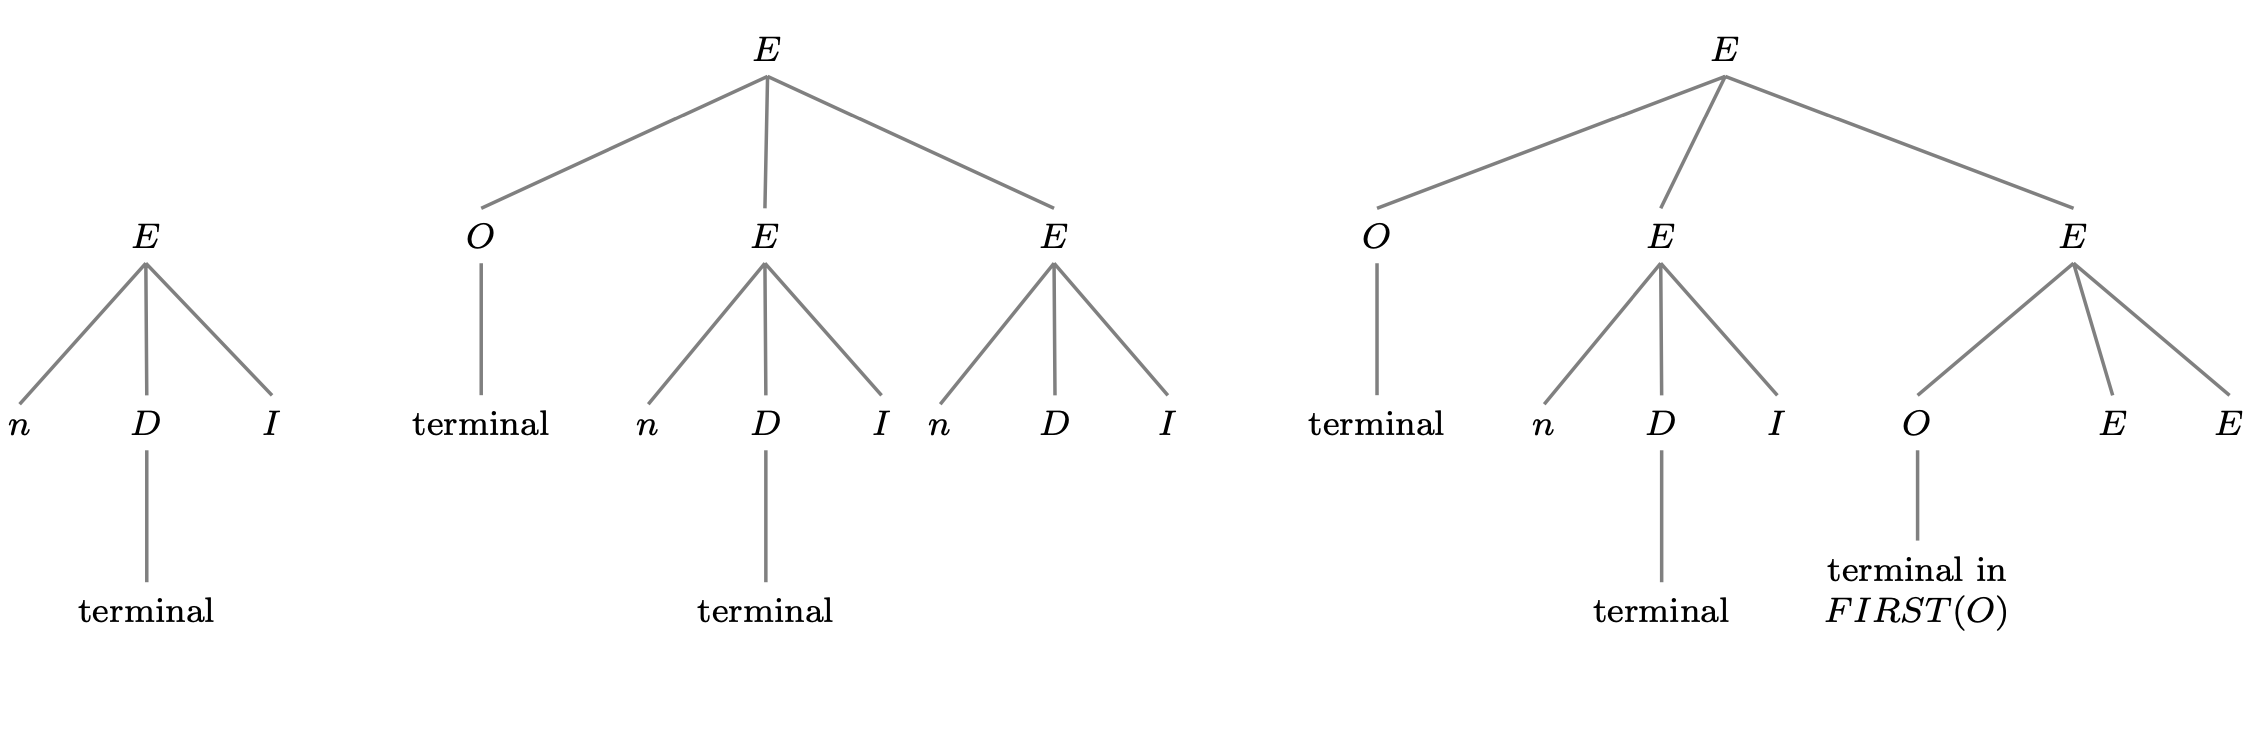

Let's construct a class for the recursive descent parser (RDP). There will be a function for each nonterminal and a function to test whether the current input character is what the grammar expects either in its FIRST or its FOLLOW sets. We'll call this testing function `_match`.

Let's first implement our own exception type like we did in the previous tutorial.

In [4]:
class ParseErrorException(Exception):
    """ Class for parsing errors.
    
    A parse error is when any of the following errors occur:
       1. the current input is not in the FIRST set of any production
       2. we expect to see another input but all the inputs have been processed
       3. we have processed everthing on the stack but still have inputs. """
    
    def __init__(self, message: str = "A parse error occurred ") -> None:
        super().__init__(message)
        self._message = message

We can now define our parser. The structure is almost identical to the previous tutorial, but when we are processing nonterminal $I$ we will check the FOLLOW set too.

In [5]:
from typing import Iterator
from typing import Callable as function
class Parser:
    def __init__(self) -> None:
        self._starting_nonterminal: function[[], None] = self.E_nonterminal  # Starting nonterminal
        
    def parse(self, input: Iterator) -> None:
        self._input = input
        self._current_input = next(self._input) # Read the first char and advance the iterator
        self._starting_nonterminal() # Start the recursion by calling the starting nonterminal
        
        if self._current_input == '#':
            print("Parse successful")
        else:
            raise ParseErrorException("At least one input was unprocessed")
        
        return
    
 
    ################################################################
    # Each nonterminal gets its own function.                      #
    # The function knows which productions have the nonterminal on #
    # the left hand side of the production. The correct right      #
    # hand side of the production is chosen by looking at the      #
    # current input and the FIRST set of the right hand side       #
    ################################################################
    def E_nonterminal(self) -> None:
        """ Production E--> nDI | OEE """
        ################################################################
        # Define FIRST sets for the right hand side of each production #
        ################################################################
        first: dict[str, set[str]] = dict()
        first['OEE'] = {'+', '-'}
        first['nDI'] = {'n'}

        if self._current_input in first['OEE']:
            # Push OEE onto the stack
            self.O_nonterminal()
            self.E_nonterminal()
            self.E_nonterminal()
        elif self._current_input in first['nDI']:
            self._current_input = next(self._input) # Advance the nonterminal
            self.D_nonterminal()
            self.I_nonterminal()
        else: 
            error_message = f"Input {self._current_input} is not in the first set of nonterminal E"
            raise ParseErrorException(error_message)

        return # Pops this nonterminal from the stack
    
    def I_nonterminal(self) -> None:
        """ Production I --> DI | lambda """
        ################################################################
        # Define FIRST sets for the righthand side of each production  #
        ################################################################
        first: dict[str, set[str]] = dict()
        first['DI'] = {'0', '1', '2', '3'}
        ################################################################
        # Define FOLLOW sets for the lefthand side of the production   #
        ################################################################
        follow: dict[str, set[str]] = dict()
        follow['I'] = {'#', 'n', '+', '*'}

        if self._current_input in first['DI']:
            # Push OEE onto the stack
            self.D_nonterminal()
            self.I_nonterminal()
        elif self._current_input in follow['I']:
            # Pop I from the stack, which stops recursively generating desendants
            # and allows the next part of the parse tree to be created
            return 
        else: 
            error_message = f"Input {self._current_input} is neither in the first set nor the follow set of nonterminal I"
            raise ParseErrorException(error_message)
        
    def D_nonterminal(self) -> None:
        """ Production N --> 0 | 1 | 2 | 3 """
        if self._match('0') or self._match('1') or self._match('2') or self._match('3'):
            self._current_input = next(self._input)
        else: 
            error_message = f"Input {self._current_input} cannot be produced by nonterminal N"
            raise ParseErrorException(error_message)

        return # Pops this nonterminal from the stack
    
    def O_nonterminal(self) -> None:
        """ Production O --> + | * """        
        if self._match('+') or self._match('*'):
            self._current_input = next(self._input)
        else: 
            error_message = f"Input {self._current_input} cannot be produced by nonterminal O"
            raise ParseErrorException(error_message)

        return # Pops this nonterminal from the stack
   
    def _match(self, input:str) -> bool:
        return self._current_input == input

Everthing is almost identical except that the function for the nonterminal $I$ checks both the FIRST and FOLLOW sets to decide what to do.  Let's test it.

In [ ]:
parser = Parser()
input = iter("+n12n30#")
try:
    parser.parse(input)
except ParseErrorException as message:
    print(message)

In [ ]:
input = iter("+n2n3#")
try:
    parser.parse(input)
except ParseErrorException as message:
    print(message)

In [ ]:
input = iter("+n23#")
try:
    parser.parse(input)
except ParseErrorException as message:
    print(message)